# AI 4 StoryLines - BHM + GP + VI

In this example, we are going to showcase how we can do sensitivity analysis using a simple linear regression model.

In [1]:
import autoroot
import arviz as az
import numpyro
import numpy as np
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro.infer import Predictive, SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoDelta
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
import jax
import jax.random as jrandom
import jax.numpy as jnp
from jaxtyping import Array, Float
from pathlib import Path
from dataclasses import dataclass
import xarray as xr
import pandas as pd
import einops
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from bayesevt._src.utils.io import get_list_filenames
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
%matplotlib inline
%load_ext autoreload
%autoreload 2

We can see that there is some explained variance that is missing.
Potentially we can explain this with the regression model.

## Load Data

We have a clean analysis-ready dataset available from the previous notebook.
We will save it and revisit it later.

First, we will make sure that the models in the covariates and the QoI are the same.

In [2]:
save_dir = "/pool/usuarios/juanjohn/data/ai4storylines/analysis/"

In [3]:
# load covariates
df = pd.read_csv(Path(save_dir).joinpath("covariates.csv"), index_col=0)
# load qoi
ds = xr.open_dataset(Path(save_dir).joinpath("qoi.nc"))
# quick check
assert df.model.values.sort() == ds.model.values.sort()
ds

<xarray.Dataset> Size: 69kB
Dimensions:    (lon: 21, lat: 19, model: 28)
Coordinates:
  * lon        (lon) float64 168B -20.0 -17.5 -15.0 -12.5 ... 25.0 27.5 30.0
  * lat        (lat) float64 152B 26.25 28.75 31.25 33.75 ... 66.25 68.75 71.25
  * model      (model) <U16 2kB 'access_cm2' 'access_esm1_5' ... 'ukesm1_0_ll'
Data variables:
    tasmax     (model, lat, lon) float32 45kB ...
    land_mask  (model, lat, lon) int16 22kB ...
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.5 (https://mpi...
    source:                 ACCESS-CM2 (2019): \naerosol: UKCA-GLOMAP-mode\na...
    institution:            CSIRO (Commonwealth Scientific and Industrial Res...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    ...                     ...
    variant_label:          r1i1p1f1
    version:                v20191108
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/9ecf99bf-2241-4c6a-acea-15d12be52c43
    license:                CMIP6 model data produced by CSIRO is licensed un...
    CDO:                    Climate Data Operators version 2.0.5 (https://mpi...

## Baseline Model - Linear Regression

#### Input Data

In [4]:
covariate_names = ["sst", "sm_sur", "t2m", "z500_zonal"]
qoi_names = ["tasmax"]
x = df.sort_values(by=["model"])[covariate_names].values
u = ds.sortby("model").tasmax.values

In [5]:
x.shape, u.shape

((28, 4), (28, 19, 21))

We see that we have the `4` covariates and the `19x21` grid points.

Linear Regression only works with a 1D vector. 
So we need to flatten the `u` variable.

In [6]:
num_models, num_features = x.shape
num_models, num_lat, num_lon = u.shape

u_flattened = einops.rearrange(u, "Model Lat Lon -> Model (Lat Lon)")


In [7]:
x_coords = jnp.linspace(0, 1, num_lon)
y_coords = jnp.linspace(0, 1, num_lat)
X_coords, Y_coords = jnp.meshgrid(x_coords, y_coords, indexing="ij")
s_coords = jnp.stack([X_coords.ravel(), Y_coords.ravel()], axis=1)

#### Model

In [8]:
num_spatial = u_flattened.shape[1]
num_models = u_flattened.shape[0]
num_covariates = x.shape[1]

In [9]:
u_flattened.shape

(28, 399)

In [10]:
from typing import Callable

def sqeuclidean_distance(x: np.array, y: np.array) -> float:
    return np.sum((x - y) ** 2)

def kernel_rbf(x: jnp.array, y: jnp.array, length_scale=1.0, variance=1.0) -> float:
    return variance * jnp.exp(- sqeuclidean_distance(x/length_scale, y/length_scale))

# def kernel_rbf(x: jnp.array, y: jnp.array, length_scale=1.0, variance=1.0) -> float:
#     return variance * jnp.exp(- length_scale * sqeuclidean_distance(x, y))

def gram(kernel_fn, x: jnp.array, y: jnp.array, *args, **kwargs) -> float:
    return jax.vmap(lambda x1: jax.vmap(lambda y1: kernel_fn(x1, y1, *args, **kwargs))(y))(x)

    

In [11]:
K = gram(kernel_rbf, s_coords, s_coords, 0.1, 0.1)

In [12]:
def mean(
    s: Float[Array, "N 2"], 
    x: Float[Array, "D"], 
    weight_x: Float[Array, "N D"], 
    weight_s: Float[Array, "2"], 
    bias: Float[Array, ""]):
    return jnp.einsum("D,ND->N", weight_s, s) + jnp.einsum("ND,D->N",weight_x, x) + bias

In [13]:
mean(s_coords, x[0], np.random.randn(num_spatial, num_features), np.random.randn(2), 1.0);

In [14]:
def model(x: Float[Array, "M D"], S: Float[Array, "N"], y: Float[Array, "M N"]=None):
    num_models, num_features = x.shape
    # noise
    scale = numpyro.sample("scale", dist.LogNormal(0.0, 10.0))
    # prior on spatial process
    variance = numpyro.sample("variance", dist.LogNormal(0.0, 10.0))
    length_scale = numpyro.sample("length_scale", dist.LogNormal(0.0, 10.0))
    K: Float[Array, "N N"] = gram(kernel_rbf, S, S, length_scale=length_scale, variance=variance) 
    K += (scale + 1e-6) * jnp.eye(K.shape[0])

    # weights & biases
    with numpyro.plate("spatial", num_spatial), numpyro.plate("covariates", num_features):
        weight: Float[Array, "N D"] = numpyro.sample("weight", dist.Normal(0.0, 2.0))

    weight_s: Float[Array, "N D"] = numpyro.sample("weight_s", dist.Normal(0.0, 2.0), sample_shape=(2,))
    with numpyro.plate("spatial", num_spatial):
        # sample bias
        bias: Float[Array, "N"] = numpyro.sample("bias", dist.Normal(0.0, 2.0))
        
    # sample spatial process
    z = jax.vmap(mean, in_axes=(None,0,None,None,None))(S, x, weight.T, weight_s, bias)
    f: Float[Array, "M"] = numpyro.sample("obs", dist.MultivariateNormal(loc=z, covariance_matrix=K), obs=y)

    

In [15]:
prior_predictive = Predictive(model, num_samples=10)
prior_samples = prior_predictive(jrandom.PRNGKey(0), x=x, S=s_coords)
# prior_samples

In [16]:
prior_samples["bias"].shape
prior_samples["weight"].shape

(10, 4, 399)

In [17]:
weights = einops.rearrange(prior_samples["weight"][0], "Variable (Lat Lon)  -> Variable Lat Lon", Lat=u.shape[1], Lon=u.shape[2])

In [18]:
# sea surface height
ds["sst_weights"] = (("lat", "lon"), weights[0])
ds["sst_weights"].attrs["standard_name"] = "Weights"

# soil moisture
ds["sm_weights"] = (("lat", "lon"), weights[1])
ds["sm_weights"].attrs["standard_name"] = "Weights"

# 2m Temperature
ds["t2m_weights"] = (("lat", "lon"), weights[2])
ds["t2m_weights"].attrs["standard_name"] = "Weights"

# Geopotential @ 500
ds["z500_zonal_weights"] = (("lat", "lon"), weights[3])
ds["z500_zonal_weights"].attrs["standard_name"] = "Weights"

In [19]:
from utils import plot_weights

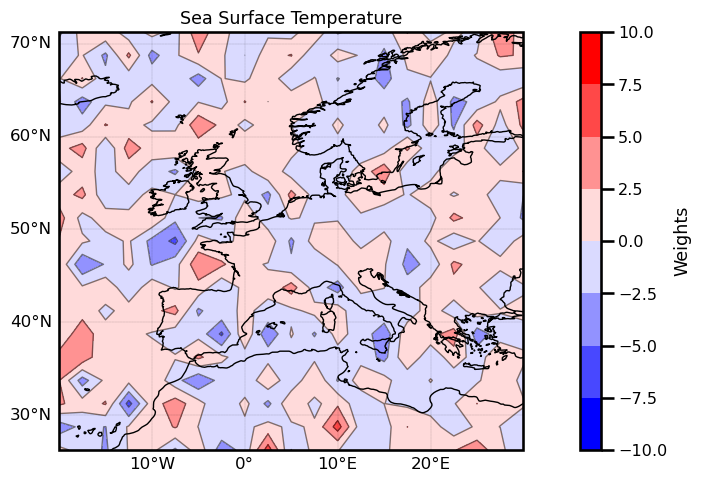

In [20]:
plot_weights(ds.sst_weights, "Sea Surface Temperature", vmin=-10, vmax=10);

### Variational Distribution

In [21]:
from numpyro.infer.autoguide import AutoDelta, AutoMultivariateNormal, AutoBNAFNormal, AutoLaplaceApproximation

guide = AutoLaplaceApproximation(model)

### Inference

$$
\boldsymbol{\phi}^* = 
\underset{\boldsymbol{\phi}}{\text{argmin}}
\hspace{2mm}
\text{ELBO}_{q}
\left[q(\boldsymbol{\theta};\boldsymbol{\phi}), p(y,\boldsymbol{\theta})\right]
$$

In [22]:
from numpyro.infer import Predictive, SVI, Trace_ELBO
optimizer = numpyro.optim.Adam(step_size=0.001)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

In [23]:
num_steps = 2_000
rng_key = jrandom.PRNGKey(123)
rng_key_train, rng_key = jrandom.split(rng_key, num=2)

svi_result = svi.run(rng_key=rng_key_train, num_steps=num_steps, x=x, S=s_coords, y=u_flattened)

100%|█| 2000/2000 [00:03<00:00, 620.48it/s, init loss: 1340771.2500, avg. loss [


### Training

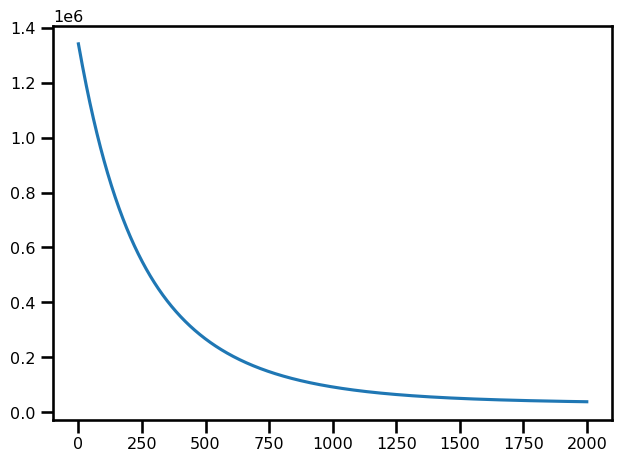

In [24]:
fig, ax = plt.subplots()
ax.plot(svi_result.losses)
plt.tight_layout()
plt.show()

### Posterior Samples

In [25]:
params = svi_result.params
# samples = guide.get_posterior(params)
predictive = Predictive(guide, params=params, num_samples=1000)
posterior_samples = predictive(jrandom.PRNGKey(0), x=x, s=s_coords)
# posterior_samples

In [26]:
posterior_samples["weight"].shape, 

((1000, 4, 399),)

### Post-Model Analysis

We can extract the parameters for the regression model.
The coefficient corresponds to the slope of the regression model.

We want to plot the coefficient for each of the variables.
First, we need to reshape the 1D Vector to be a `lat-lon` vector.

In [27]:
list(posterior_samples.keys())

['_auto_latent',
 'bias',
 'length_scale',
 'scale',
 'variance',
 'weight',
 'weight_s']

In [28]:
# plt.imshow(posterior_samples["f"].reshape(u_shape)

In [29]:
weights = einops.rearrange(posterior_samples["weight"], "... Variable (Lat Lon)  -> ... Lat Lon Variable", Lat=u.shape[1], Lon=u.shape[2])

In [30]:
ds = ds.assign_coords(
    coords={
        "samples": np.arange(0,len(posterior_samples["weight"])),
    })
ds["sst_weights"] = (("samples", "lat", "lon"), weights[...,0])
ds

<xarray.Dataset> Size: 2MB
Dimensions:             (lon: 21, lat: 19, model: 28, samples: 1000)
Coordinates:
  * lon                 (lon) float64 168B -20.0 -17.5 -15.0 ... 25.0 27.5 30.0
  * lat                 (lat) float64 152B 26.25 28.75 31.25 ... 68.75 71.25
  * model               (model) <U16 2kB 'access_cm2' ... 'ukesm1_0_ll'
  * samples             (samples) int64 8kB 0 1 2 3 4 5 ... 995 996 997 998 999
Data variables:
    tasmax              (model, lat, lon) float32 45kB ...
    land_mask           (model, lat, lon) int16 22kB ...
    sst_weights         (samples, lat, lon) float32 2MB -0.04692 ... -0.3828
    sm_weights          (lat, lon) float32 2kB -2.107 -2.895 ... -2.998 -1.121
    t2m_weights         (lat, lon) float32 2kB 2.787 4.368 ... 3.051 2.695
    z500_zonal_weights  (lat, lon) float32 2kB 0.8142 -0.03705 ... -0.1596
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.5 (https://mpi...
    source:                 ACCESS-CM2 (2019): \naerosol: UKCA-GLOMAP-mode\na...
    institution:            CSIRO (Commonwealth Scientific and Industrial Res...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    ...                     ...
    variant_label:          r1i1p1f1
    version:                v20191108
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/9ecf99bf-2241-4c6a-acea-15d12be52c43
    license:                CMIP6 model data produced by CSIRO is licensed un...
    CDO:                    Climate Data Operators version 2.0.5 (https://mpi...

Now, we will add each of these to our dataset so that we can see our

In [31]:
# sea surface height
ds["sst_weights"] = (("samples", "lat", "lon"), weights[...,0])
ds["sst_weights"].attrs["standard_name"] = "Weights"

# soil moisture
ds["sm_weights"] = (("samples", "lat", "lon"), weights[...,1])
ds["sm_weights"].attrs["standard_name"] = "Weights"

# 2m Temperature
ds["t2m_weights"] = (("samples", "lat", "lon"), weights[...,2])
ds["t2m_weights"].attrs["standard_name"] = "Weights"

# Geopotential @ 500
ds["z500_zonal_weights"] = (("samples", "lat", "lon"), weights[...,3])
ds["z500_zonal_weights"].attrs["standard_name"] = "Weights"

## Analysis Dataset

In [32]:
vmin = -2.0
vmax = 2.0
chain = 1
import numpy as np

In [33]:
np.linspace(-2.0, 2.0, 10)

array([-2.        , -1.55555556, -1.11111111, -0.66666667, -0.22222222,
        0.22222222,  0.66666667,  1.11111111,  1.55555556,  2.        ])

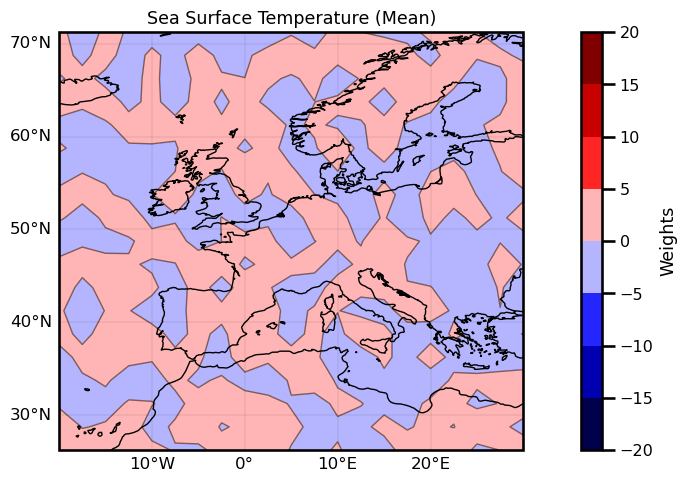

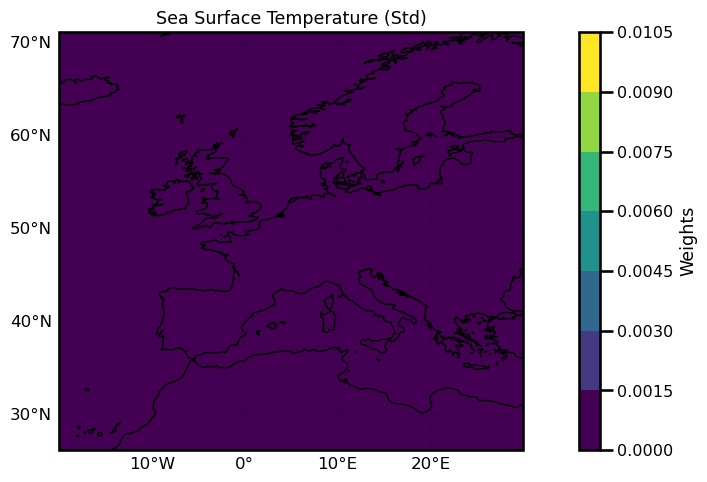

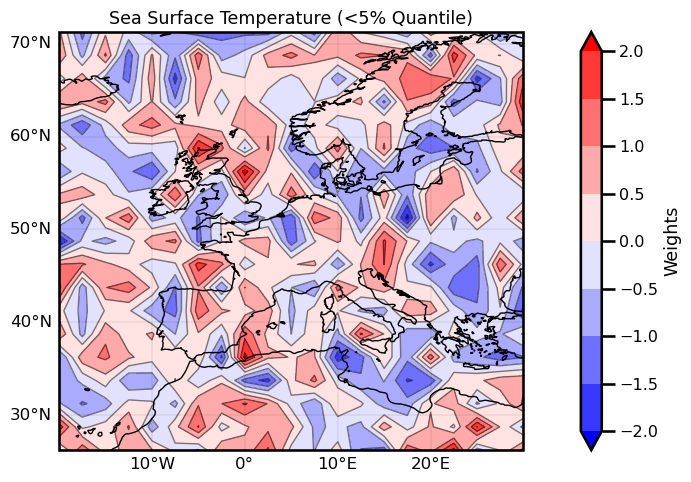

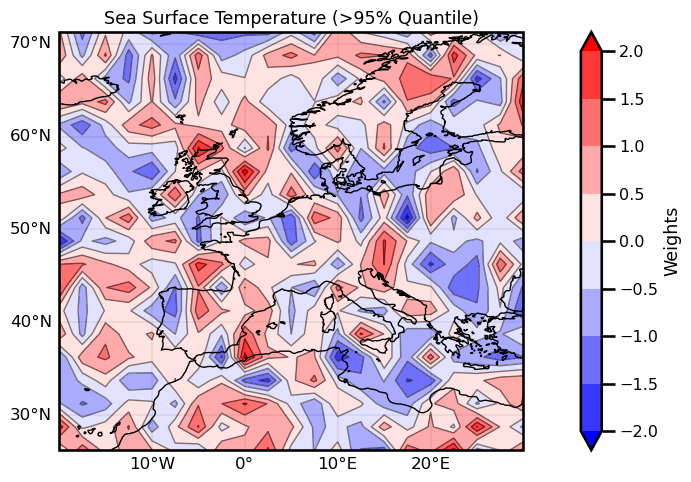

In [34]:
# Sea Surface Temperature
plot_weights(ds.sst_weights.mean(["samples"], keep_attrs=True), "Sea Surface Temperature (Mean)", vmin=-20.0, vmax=20.0, cmap="seismic", num_levels=8);
plot_weights(ds.sst_weights.std(["samples"], keep_attrs=True), "Sea Surface Temperature (Std)", vmin=0.0, vmax=0.01, cmap="viridis");
plot_weights(ds.sst_weights.quantile(q=0.05, dim=["samples"], keep_attrs=True), r"Sea Surface Temperature (<5% Quantile)", vmin=-2.0, vmax=2.0);
plot_weights(ds.sst_weights.quantile(q=0.95, dim=["samples"], keep_attrs=True), "Sea Surface Temperature (>95% Quantile)", vmin=-2.0, vmax=2.0);


#### Soil Moisture

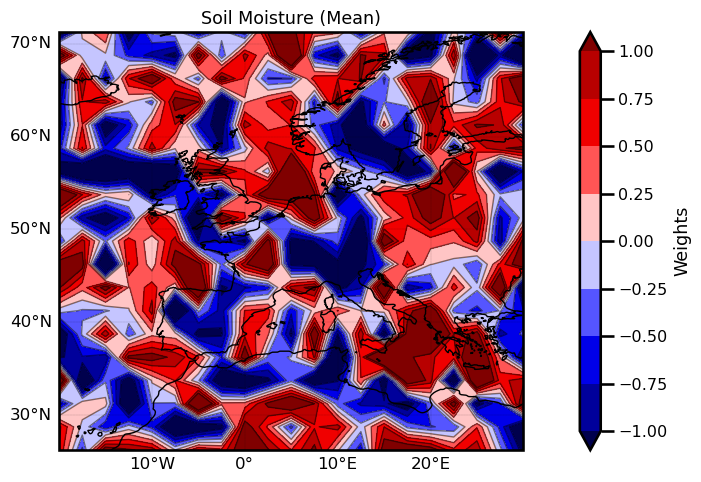

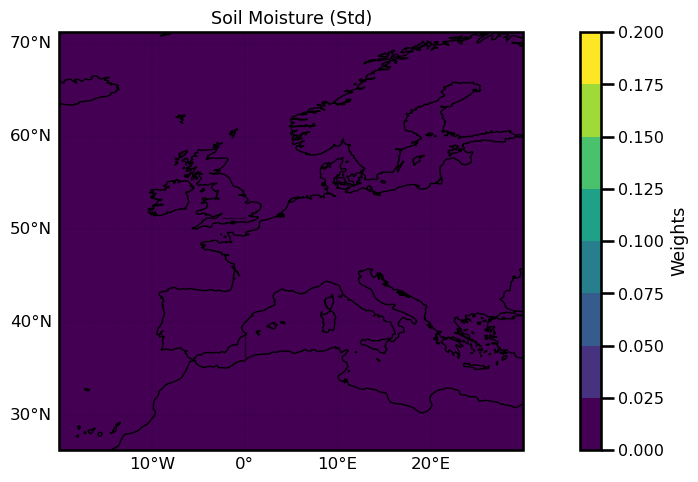

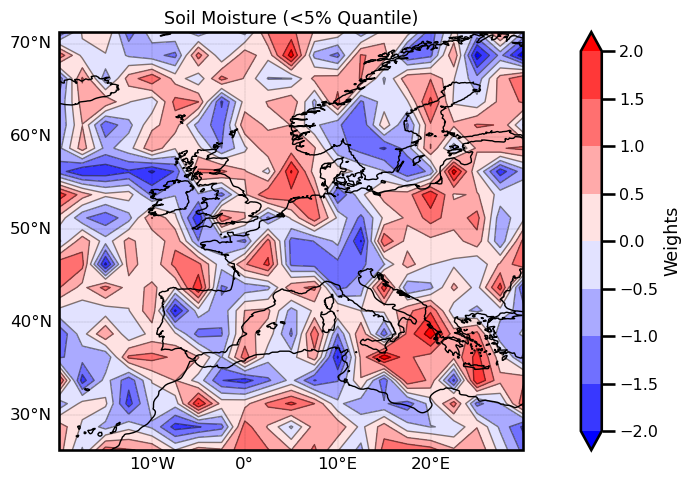

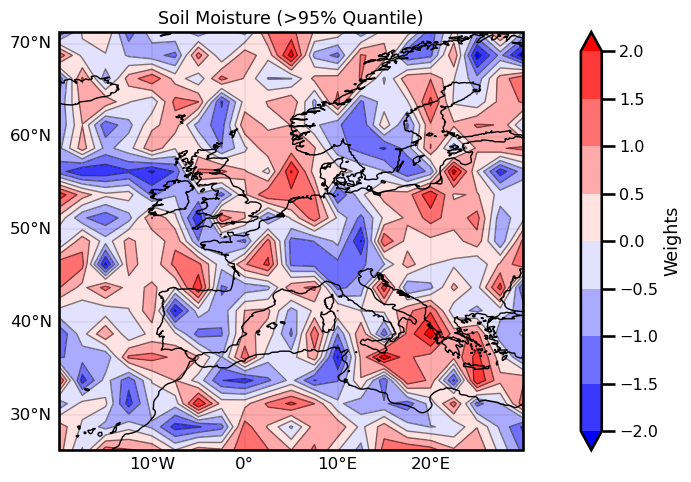

In [35]:
# Sea Surface Temperature
plot_weights(ds.sm_weights.mean(["samples"], keep_attrs=True), "Soil Moisture (Mean)", vmin=-1.0, vmax=1.0, cmap="seismic", num_levels=8);
plot_weights(ds.sm_weights.std(["samples"], keep_attrs=True), "Soil Moisture (Std)", vmin=0.0, vmax=0.20, cmap="viridis");
plot_weights(ds.sm_weights.quantile(q=0.05, dim=["samples"], keep_attrs=True), r"Soil Moisture (<5% Quantile)", vmin=-2.0, vmax=2.0);
plot_weights(ds.sm_weights.quantile(q=0.95, dim=["samples"], keep_attrs=True), "Soil Moisture (>95% Quantile)", vmin=-2.0, vmax=2.0);


#### 2M Temperature

In [36]:
# Sea Surface Temperature
plot_weights(ds.t2m_weights.mean(["draw"], keep_attrs=True).isel(chain=chain), "2m Temperature (Mean)", vmin=-2.0, vmax=2.0, cmap="seismic", num_levels=8);
plot_weights(ds.t2m_weights.std(["draw"], keep_attrs=True).isel(chain=chain), "2m Temperature (Std)", vmin=0.0, vmax=0.28, cmap="viridis");
plot_weights(ds.t2m_weights.quantile(q=0.05, dim=["draw"], keep_attrs=True).isel(chain=chain), r"2m Temperature (<5% Quantile)", vmin=-2.0, vmax=2.0, num_levels=8);
plot_weights(ds.t2m_weights.quantile(q=0.95, dim=["draw"], keep_attrs=True).isel(chain=chain), "2m Temperature (>95% Quantile)", vmin=-2.0, vmax=2.0, num_levels=8);


ValueError: 'draw' not found in array dimensions ('samples', 'lat', 'lon')

#### Geopotential

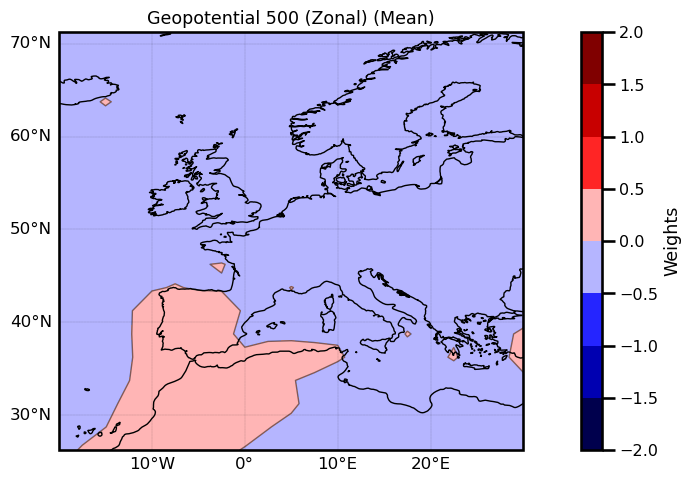

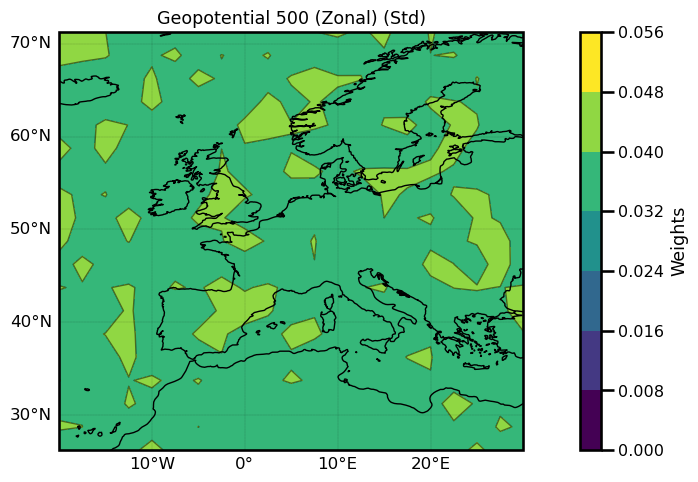

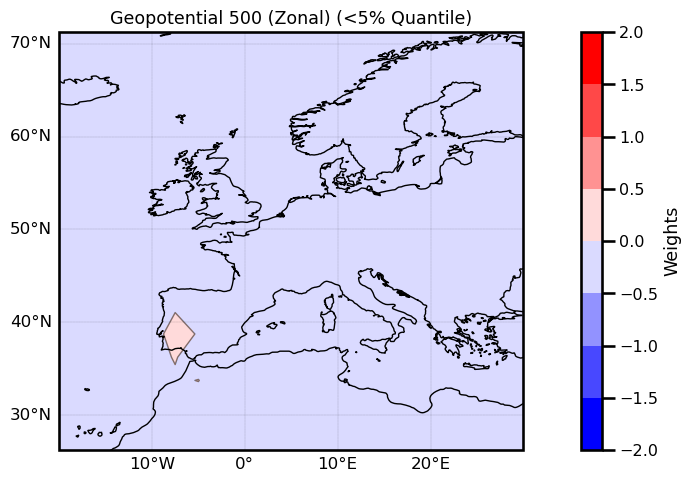

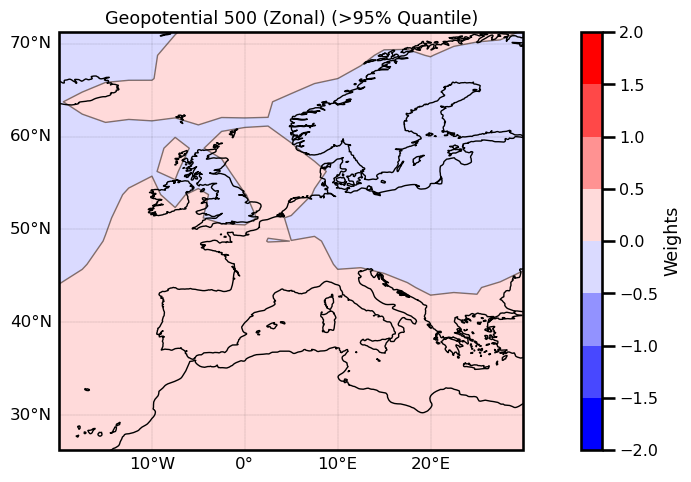

In [57]:
# Geopotential
plot_weights(ds.z500_zonal_weights.mean(["draw"], keep_attrs=True).isel(chain=chain), "Geopotential 500 (Zonal) (Mean)", vmin=-2.0, vmax=2.0, cmap="seismic", num_levels=8);
plot_weights(ds.z500_zonal_weights.std(["draw"], keep_attrs=True).isel(chain=chain), "Geopotential 500 (Zonal) (Std)", vmin=0.0, vmax=0.05, cmap="viridis");
plot_weights(ds.z500_zonal_weights.quantile(q=0.05, dim=["draw"], keep_attrs=True).isel(chain=chain), r"Geopotential 500 (Zonal) (<5% Quantile)", vmin=-2.0, vmax=2.0);
plot_weights(ds.z500_zonal_weights.quantile(q=0.95, dim=["draw"], keep_attrs=True).isel(chain=chain), "Geopotential 500 (Zonal) (>95% Quantile)", vmin=-2.0, vmax=2.0);


## Things to Do


* Standardize Input/Output Data (see [sklearn.preprocessing](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing))
* Find the Best Parameters with Cross Validation
* Choose a Better Linear Model ([LASSO](https://scikit-learn.org/stable/modules/linear_model.html#lasso), [LARS](https://scikit-learn.org/stable/modules/linear_model.html#least-angle-regression), [Elastic-Net](https://scikit-learn.org/stable/modules/linear_model.html#elastic-net), [Generalized Linear Model](https://scikit-learn.org/stable/modules/linear_model.html#generalized-linear-models), [Quantile Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.QuantileRegressor.html#sklearn.linear_model.QuantileRegressor))